CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

Define the model class.

In [2]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels, drop_out):
        super(MLP, self).__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [3]:
from common_utils import split_dataset, preprocess_dataset

df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].str.split('.').str[0]
df_train, y_train, df_test, y_test = split_dataset(df= df, columns_to_drop= ['filename', 'label'],
                                                   test_size= 0.3, random_state= 10)

df_train_scaled, df_test_scaled = preprocess_dataset(df_train, df_test)

In [8]:
display(df)

,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,0
1,blues.00000.1.wav,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,0
2,blues.00000.2.wav,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,0
3,blues.00000.3.wav,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,0
4,blues.00000.4.wav,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,metal.00099.5.wav,0.569740,0.062489,0.183593,0.002789,2535.203233,270668.548858,2291.959926,58613.589717,5130.285645,...,21.712755,-4.158046,29.863869,9.435037,26.915369,0.012259,23.633455,3.567852,28.382370,1
1996,metal.00099.6.wav,0.515344,0.070363,0.163011,0.002171,2343.927920,196117.813927,2247.395310,52294.899740,4876.525128,...,22.578876,-5.004858,20.476982,7.884581,23.147270,0.954583,40.513123,3.694663,13.842016,1
1997,metal.00099.7.wav,0.516211,0.076836,0.192291,0.002663,2391.415667,210603.079200,2310.871644,30626.337841,5062.041955,...,31.324835,-4.537669,27.974548,8.396358,20.044083,0.623945,28.704712,2.352662,17.750040,1
1998,metal.00099.8.wav,0.535496,0.069590,0.164871,0.002717,2250.460272,164674.801773,2198.307164,33464.557313,4684.962440,...,18.584599,-5.836212,9.423578,7.213720,16.957996,0.295297,23.082623,2.749243,16.626318,1


> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

In [4]:
no_epoch = 100
lr = 0.001
batch_size = 256
patience = 3

input_features = 77
hidden_depth = 128
output_features = 1
dropout = 0.2

1. Define a Pytorch Dataset and Dataloaders.  

In [5]:
# TODO: Need to learn what is going on here
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_data = MyDataset(df_train_scaled, y_train)
test_data = MyDataset(df_test_scaled, y_test)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

2. Next, define the model, optimizer and loss function.

In [6]:
model = MLP(input_features, hidden_depth, output_features, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += ((pred > 0.5).float() == y).all(dim=1).sum().item()
    
    train_loss /= size
    train_correct /= size

    return train_loss, train_correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            loss = loss_fn(pred, y)

            test_loss += loss.item()
            test_correct += ((pred > 0.5).float() == y).all(dim=1).sum().item()

    test_loss /= size
    test_correct /= size

    return test_loss, test_correct


In [8]:
from common_utils import EarlyStopper

early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []

for t in range(no_epoch):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)

    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if early_stopper.early_stop(test_loss):
        print("Done!")
        break

Epoch 1: Train_accuracy: 48.57%, Train_loss: 0.004929, Test_accuracy: 60.00%, Test_loss: 0.011153
Epoch 2: Train_accuracy: 56.43%, Train_loss: 0.004820, Test_accuracy: 73.33%, Test_loss: 0.010892
Epoch 3: Train_accuracy: 70.71%, Train_loss: 0.004706, Test_accuracy: 83.33%, Test_loss: 0.010637
Epoch 4: Train_accuracy: 82.14%, Train_loss: 0.004549, Test_accuracy: 81.67%, Test_loss: 0.010278
Epoch 5: Train_accuracy: 81.43%, Train_loss: 0.004397, Test_accuracy: 80.00%, Test_loss: 0.010114
Epoch 6: Train_accuracy: 85.00%, Train_loss: 0.004202, Test_accuracy: 81.67%, Test_loss: 0.009606
Epoch 7: Train_accuracy: 83.57%, Train_loss: 0.004051, Test_accuracy: 76.67%, Test_loss: 0.009118
Epoch 8: Train_accuracy: 82.14%, Train_loss: 0.003822, Test_accuracy: 76.67%, Test_loss: 0.008856
Epoch 9: Train_accuracy: 84.29%, Train_loss: 0.003572, Test_accuracy: 78.33%, Test_loss: 0.008318
Epoch 10: Train_accuracy: 82.86%, Train_loss: 0.003388, Test_accuracy: 78.33%, Test_loss: 0.008156
Epoch 11: Train_acc

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

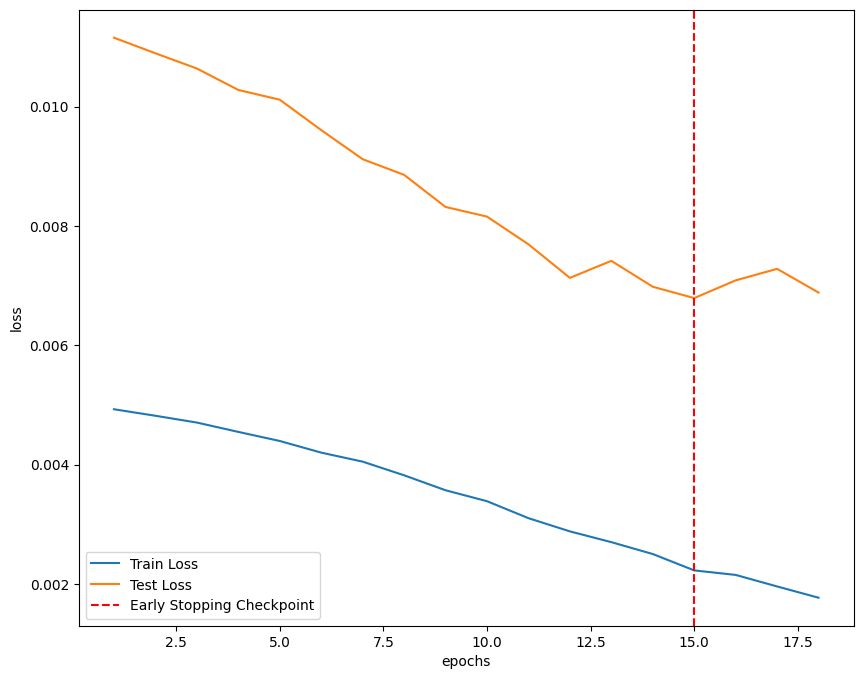

In [9]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Train Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Test Loss')

minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

\# TODO: \<Enter your answer here\>

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [ ]:
from common_utils import MLP
from common_utils import split_dataset, preprocess_dataset

df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].str.split('.').str[0]
df_train, y_train, df_test, y_test = split_dataset(df= df, columns_to_drop= ['filename', 'label'],
                                                   test_size= 0.3, random_state= 10)

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [41]:
batch_sizes = [128, 256, 512, 1024]

def create_datasets(rseed, y_train, df_train):
    cv = KFold(n_splits=5, shuffle=True, random_state=rseed)
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    y_train_fold = y_train.copy()
    df_train_fold = df_train.copy()

    for batch_size in batch_sizes:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []
        for train_idx, test_idx in cv.split(df_train_fold, y_train_fold):
            x_train, x_val = df_train_fold.iloc[train_idx], df_train_fold.iloc[test_idx]
            y_train, y_val = y_train_fold[train_idx], y_train_fold[test_idx]

            x_train_scaled, x_val_scaled = preprocess_dataset(x_train, x_val)

            X_train_scaled_dict[batch_size].append(x_train_scaled)
            X_val_scaled_dict[batch_size].append(x_val_scaled)
            y_train_dict[batch_size].append(y_train)
            y_val_dict[batch_size].append(y_val)
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [42]:
def hyperparam_tune_for_batchsize(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict):
    acc = []
    times = []
    for batch_size in batch_sizes:
        X_train = X_train_scaled_dict[batch_size]
        X_val = X_val_scaled_dict[batch_size]
        y_train = y_train_dict[batch_size]
        y_val = y_val_dict[batch_size]

        acc_ = []
        times_ = []

        for i in range(len(X_train)):

            train_data = MyDataset(X_train[i], y_train[i])
            val_data = MyDataset(X_val[i], y_val[i])

            train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

            model = MLP(input_features, hidden_depth, output_features, dropout)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn = nn.BCELoss()
            early_stopper = EarlyStopper(patience=patience, min_delta=0)

            last_time = 0

            for t in range(no_epoch):
                start = time.time()

                train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
                test_loss, test_correct = test_loop(val_dataloader, model, loss_fn)

                end = time.time()
                last_time = end - start

                if early_stopper.early_stop(test_loss):
                    break
            
            acc_.append(test_correct)
            times_.append(last_time)
        
        acc.append(sum(acc_) / len(acc_) * 100)
        times.append(sum(times_) / len(times_))

    return acc, times

In [49]:
acc = []
times = []
no_exp = 20

for exp in range(no_exp):
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = create_datasets(exp, y_train, df_train)
    a, t = hyperparam_tune_for_batchsize(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict)
    
    acc.append(a)
    times.append(t)
    print(f'Experiment {exp+1}: cv_acc {a}' )

mean_acc = np.mean(np.array(acc), axis = 0)
mean_times = np.mean(np.array(times), axis = 0)
print('Mean accuracy %s'%(mean_acc))

Experiment 1: cv_acc [88.57142857142858, 90.00000000000001, 87.14285714285715, 92.14285714285715]
Experiment 2: cv_acc [85.71428571428571, 93.57142857142857, 85.71428571428571, 87.85714285714285]
Experiment 3: cv_acc [92.14285714285714, 87.14285714285715, 89.28571428571429, 87.85714285714285]
Experiment 4: cv_acc [92.85714285714286, 90.71428571428572, 87.85714285714286, 90.0]
Experiment 5: cv_acc [87.85714285714286, 89.28571428571429, 85.71428571428571, 85.71428571428574]
Experiment 6: cv_acc [92.14285714285714, 89.28571428571429, 86.42857142857142, 91.42857142857143]
Experiment 7: cv_acc [91.42857142857143, 93.57142857142857, 87.85714285714286, 90.0]
Experiment 8: cv_acc [86.42857142857144, 87.14285714285715, 88.57142857142858, 84.28571428571429]
Experiment 9: cv_acc [91.42857142857143, 89.28571428571429, 89.28571428571429, 92.14285714285715]
Experiment 10: cv_acc [95.0, 90.71428571428571, 89.28571428571429, 93.57142857142857]
Experiment 11: cv_acc [88.57142857142858, 90.7142857142857

3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {128, 256, 512, 1024}.

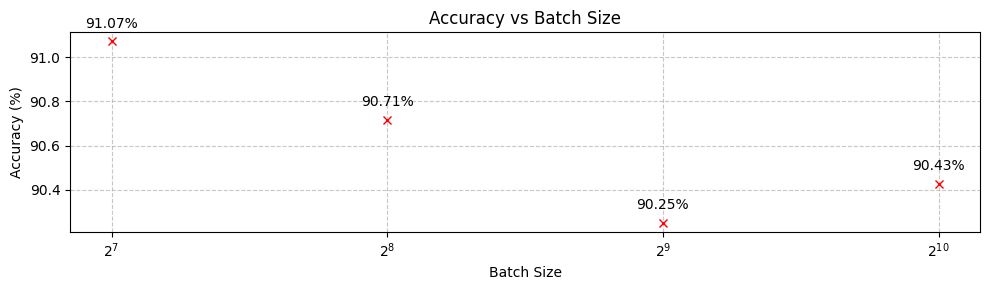

In [48]:
plt.figure(figsize=(10, 3))
plt.plot(batch_sizes, mean_acc, marker='x', linestyle='None', color='red')

plt.xlabel('Batch Size')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Batch Size')

plt.grid(True, linestyle='--', alpha=0.7)

for i, (x, y) in enumerate(zip(batch_sizes, mean_acc)):
    plt.annotate(f'{y:.2f}%', (x, y), textcoords="offset points", 
                 xytext=(0,10), ha='center')

plt.xscale('log', base=2)

plt.tight_layout()
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [50]:
df_times = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Time (seconds)': mean_times
})

display(df_times)

,Batch Size,Time (seconds)
0,128,0.001240
1,256,0.001204
2,512,0.001210
3,1024,0.001200


5. Select the optimal batch size and state a reason for your selection.

\# TODO: \<Enter your answer here\>

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [ ]:
from common_utils import MLP
from common_utils import split_dataset, preprocess_dataset

df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].str.split('.').str[0]
df_train, y_train, df_test, y_test = split_dataset(df= df, columns_to_drop= ['filename', 'label'],
                                                   test_size= 0.3, random_state= 10)
df_train_scaled, df_test_scaled = preprocess_dataset(df_train, df_test)

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [52]:
neuron_nums = [64, 128, 256]
optimal_batch_size = 128

def hyperparam_tune_for_neurons(rseed):
    acc = []
    cv = KFold(n_splits=5, shuffle=True, random_state=rseed)

    for train_idx, test_idx in cv.split(df_train_scaled, y_train):
        x_train_fold, y_train_fold = df_train_scaled[train_idx], y_train[train_idx]
        x_test_fold, y_test_fold = df_train_scaled[test_idx], y_train[test_idx]

        train_data = MyDataset(x_train_fold, y_train_fold)
        test_data = MyDataset(x_test_fold, y_test_fold)

        train_dataloader = DataLoader(train_data, batch_size=optimal_batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=optimal_batch_size, shuffle=True)

        acc_ = []

        for neuron_no in neuron_nums:
            model = MLP(input_features, neuron_no, output_features, dropout)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn = nn.BCELoss()
            early_stopper = EarlyStopper(patience=patience, min_delta=0)

            for epoch in range(no_epoch):
                train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
                test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

                if early_stopper.early_stop(test_loss):
                    break
            
            acc_.append(test_correct)
        acc.append(acc_)

    cv_acc = np.mean(np.array(acc), axis = 0)
    return cv_acc

In [ ]:
no_exp = 10
accuracies = []

for exp in range(no_exp):
    accuracies.append(hyperparam_tune_for_neurons(exp))
    print(f'Experiment {exp+1}: cv_acc {accuracies[exp]}' )

mean_acc = np.mean(np.array(accuracies), axis = 0)
print('mean accuracy %s'%(mean_acc))

Experiment 0: cv_acc [0.85714286 0.88571429 0.94285714]
Experiment 1: cv_acc [0.87857143 0.94285714 0.94285714]
Experiment 2: cv_acc [0.89285714 0.92857143 0.91428571]
Experiment 3: cv_acc [0.87142857 0.9        0.95714286]
Experiment 4: cv_acc [0.85       0.87142857 0.89285714]
Experiment 5: cv_acc [0.85714286 0.93571429 0.94285714]
Experiment 6: cv_acc [0.84285714 0.9        0.92857143]
Experiment 7: cv_acc [0.85714286 0.87857143 0.87142857]
Experiment 8: cv_acc [0.89285714 0.89285714 0.91428571]
Experiment 9: cv_acc [0.83571429 0.89285714 0.91428571]
mean accuracy [0.86357143 0.90285714 0.92214286]


2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

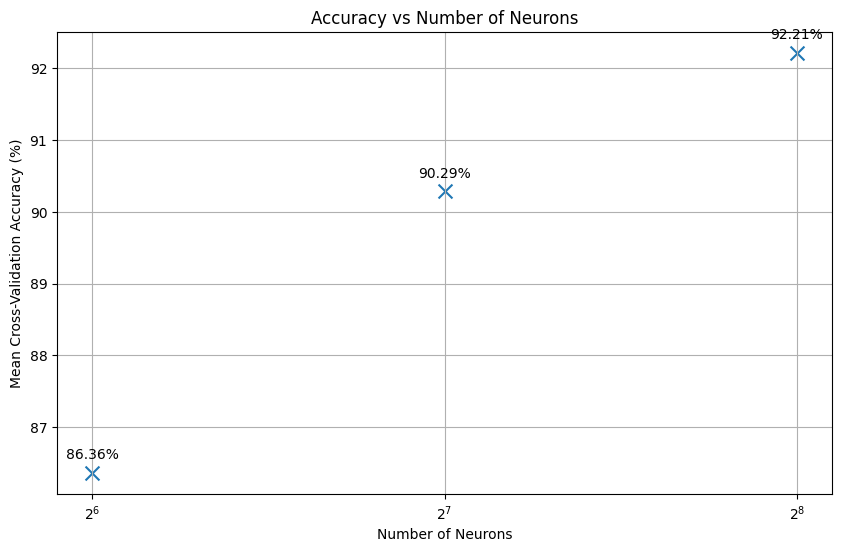

In [54]:
plt.figure(figsize=(10, 6))
plt.scatter(neuron_nums, mean_acc * 100, marker='x', linestyle='None', s=100)
plt.xlabel('Number of Neurons')
plt.ylabel('Mean Cross-Validation Accuracy (%)')
plt.title('Accuracy vs Number of Neurons')
plt.grid(True)
plt.xticks(neuron_nums)

for i, (x, y) in enumerate(zip(neuron_nums, mean_acc * 100)):
    plt.annotate(f'{y:.2f}%', (x, y), xytext=(0, 10), textcoords='offset points', ha='center')
    
plt.xscale('log', base=2)
plt.show()

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [ ]:
# TODO: Enter your code here

\# TODO: \<Enter your answer here\>

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

In [ ]:
optimal_neuron_no = 256
model = MLP(input_features, optimal_neuron_no, output_features, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
early_stopper = EarlyStopper(patience=patience, min_delta=0)

train_data = MyDataset(df_train_scaled, y_train)
test_data = MyDataset(df_test_scaled, y_test)

train_dataloader = DataLoader(train_data, batch_size=optimal_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=optimal_batch_size, shuffle=True)

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []

for t in range(no_epoch):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)

    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if early_stopper.early_stop(test_loss):
        break

Epoch 1: Train_accuracy: 47.14%, Train_loss: 0.009645, Test_accuracy: 76.67%, Test_loss: 0.010653
Epoch 2: Train_accuracy: 85.00%, Train_loss: 0.008589, Test_accuracy: 83.33%, Test_loss: 0.009507
Epoch 3: Train_accuracy: 87.14%, Train_loss: 0.007161, Test_accuracy: 76.67%, Test_loss: 0.008234
Epoch 4: Train_accuracy: 86.43%, Train_loss: 0.005822, Test_accuracy: 75.00%, Test_loss: 0.007766
Epoch 5: Train_accuracy: 87.86%, Train_loss: 0.004390, Test_accuracy: 75.00%, Test_loss: 0.007613
Epoch 6: Train_accuracy: 86.43%, Train_loss: 0.005615, Test_accuracy: 71.67%, Test_loss: 0.008600
Epoch 7: Train_accuracy: 86.43%, Train_loss: 0.003549, Test_accuracy: 80.00%, Test_loss: 0.008067
Epoch 8: Train_accuracy: 88.57%, Train_loss: 0.002793, Test_accuracy: 78.33%, Test_loss: 0.007468
Epoch 9: Train_accuracy: 91.43%, Train_loss: 0.002266, Test_accuracy: 83.33%, Test_loss: 0.007483
Epoch 10: Train_accuracy: 93.57%, Train_loss: 0.002047, Test_accuracy: 85.00%, Test_loss: 0.006981
Epoch 11: Train_acc

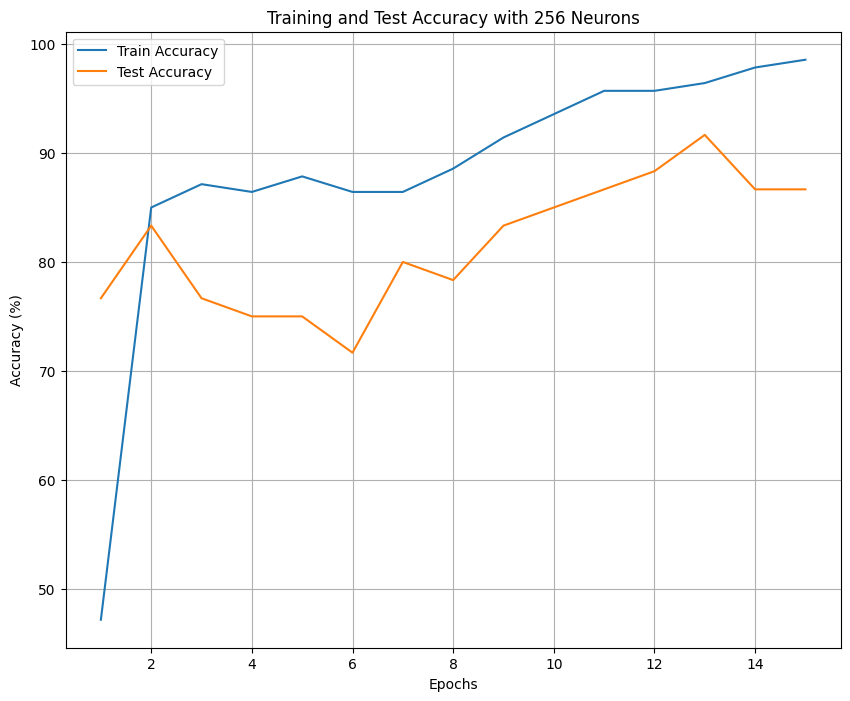

In [61]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_correct)+1), [acc*100 for acc in tr_correct], label='Train Accuracy')
plt.plot(range(1,len(te_correct)+1), [acc*100 for acc in te_correct], label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'Training and Test Accuracy with {optimal_neuron_no} Neurons')
plt.legend()
plt.grid(True)
plt.show()

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [125]:
from common_utils import MLP
from common_utils import split_dataset, preprocess_dataset, extract_features

df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].str.split('.').str[0]
df_train, y_train, df_test, y_test = split_dataset(df= df, columns_to_drop= ['filename', 'label'],
                                                   test_size= 0.3, random_state= 10)

> Install and import shap

In [ ]:
! pip install shap

/Users/yuki/Library/Mobile Documents/com~apple~CloudDocs/NTU/Y2S2/SC4001/Assignment/Assignment1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Preprocess 'blues.00031.wav' in the folder 'audio' using the function 'extract_features' in common_utils.py. Use a pandas dataframe to store the features, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [63]:
import IPython
IPython.display.Audio("./blues.00031.wav")

In [67]:
feature_set = extract_features("./blues.00031.wav")
print(feature_set)

{'filename': ['blues.00031.wav'], 'tempo': [np.float64(151.99908088235293)], 'total_beats': [np.int64(49249)], 'average_beats': [np.float64(648.0131578947369)], 'chroma_stft_mean': [np.float32(0.25371763)], 'chroma_stft_var': [np.float32(0.09932377)], 'chroma_cq_mean': [np.float32(0.27951747)], 'chroma_cq_var': [np.float32(0.082234494)], 'chroma_cens_mean': [np.float32(0.2001255)], 'chroma_cens_var': [np.float32(0.04328312)], 'melspectrogram_mean': [np.float32(6.1685324)], 'melspectrogram_var': [np.float32(2273.5356)], 'mfcc_mean': [np.float32(-9.66063)], 'mfcc_var': [np.float32(3505.035)], 'mfcc_delta_mean': [np.float32(-0.0007501749)], 'mfcc_delta_var': [np.float32(6.189438)], 'rmse_mean': [np.float32(0.15147567)], 'rmse_var': [np.float32(0.0031959515)], 'cent_mean': [np.float64(1330.6062681557464)], 'cent_var': [np.float64(352248.06857212214)], 'spec_bw_mean': [np.float64(1973.2623612410227)], 'spec_bw_var': [np.float64(234481.19141217414)], 'contrast_mean': [np.float64(27.926870947

In [126]:
# TODO: Enter your code here
df_eg = pd.DataFrame.from_dict(feature_set)
size_row = 1
size_column = len(feature_set)
display(df_eg)

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,blues.00031.wav,151.999081,49249,648.013158,0.253718,0.099324,0.279517,0.082234,0.200126,0.043283,...,-6.657476,108.960022,-14.686026,103.154343,-11.712328,115.847015,-11.020866,118.507019,-13.38948,98.540901


> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [135]:
df_eg['label'] = df_eg['filename'].str.split('.').str[0]
X_test_example = df_eg.drop(columns=['filename', 'label'])

df_train_scaled, df_test_scaled = preprocess_dataset(df_train, X_test_example)

2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [136]:
# We are going to use the final model trained in Question A3.
# The model above is trained using the optimal batch size and optimal neuron no

with torch.no_grad():
    prediction = model(torch.tensor(df_test_scaled, dtype=torch.float))
    
pred_label = (prediction > 0.5).float().item()
print(pred_label)
print("Metal" if pred_label > 0.5 else "Blues")

0.0
Blues


> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [151]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
import shap

features = df.drop(columns=['filename', 'label']).columns.tolist()
df_test_example = pd.DataFrame(df_test_scaled, columns=features)
background_data = torch.tensor(df_train_scaled[:100], dtype=torch.float) 

# Fit the explainer on a subset of the data
explainer = shap.DeepExplainer(model, background_data)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(torch.tensor(df_test_example.values).float())

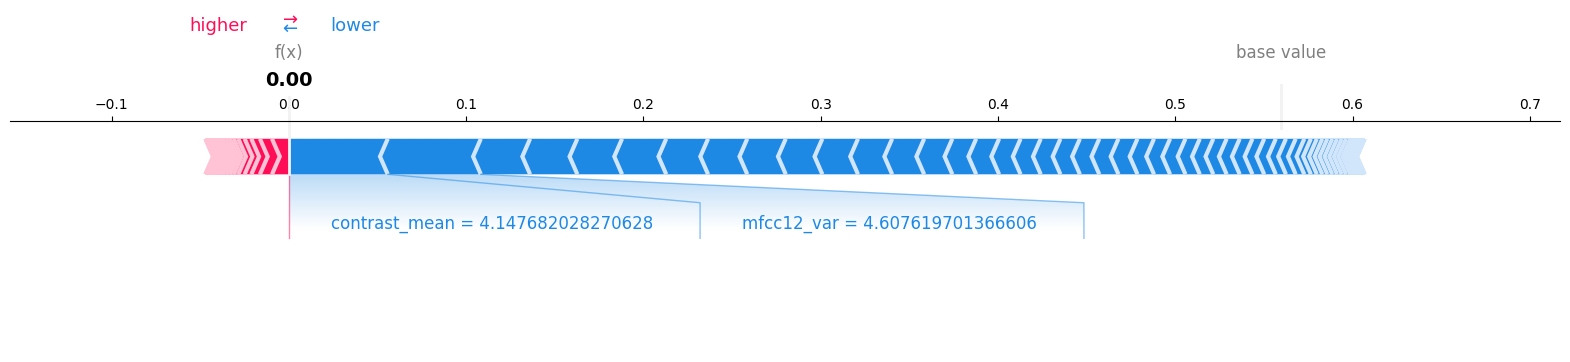

In [155]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0].T, df_test_example, matplotlib=True,show=False)


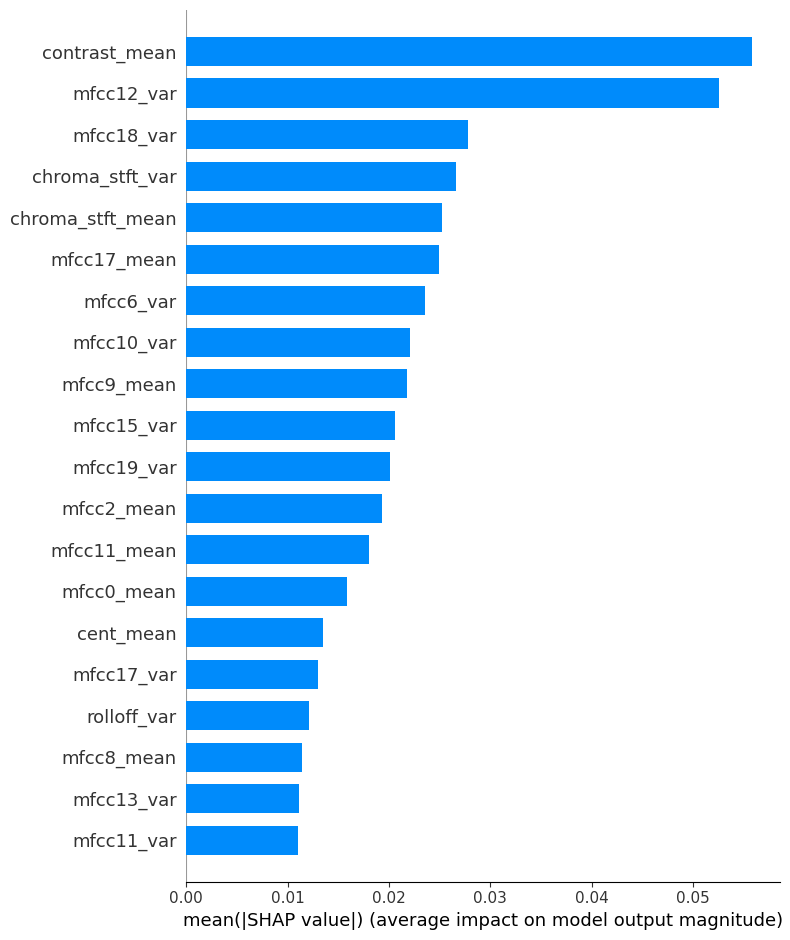

In [154]:
shap.initjs()
force_plot =shap.force_plot(explainer.expected_value[0], shap_values[0].T, features=features, figsize=(20,4))
display(force_plot)

summary_plot =shap.summary_plot(shap_values[0].T,feature_names=features,features=df_test_scaled,plot_type='bar')

\# TODO: \<Enter your answer here\>